In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps"
out_dir = "checkpoint/base"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)

# Load tokenizer 

meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_83255/2826483081.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


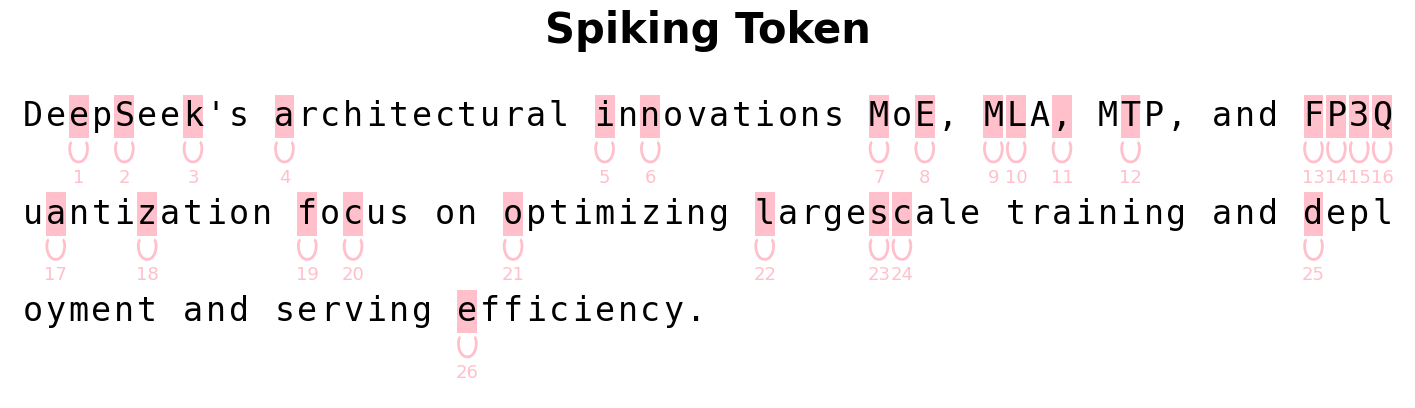

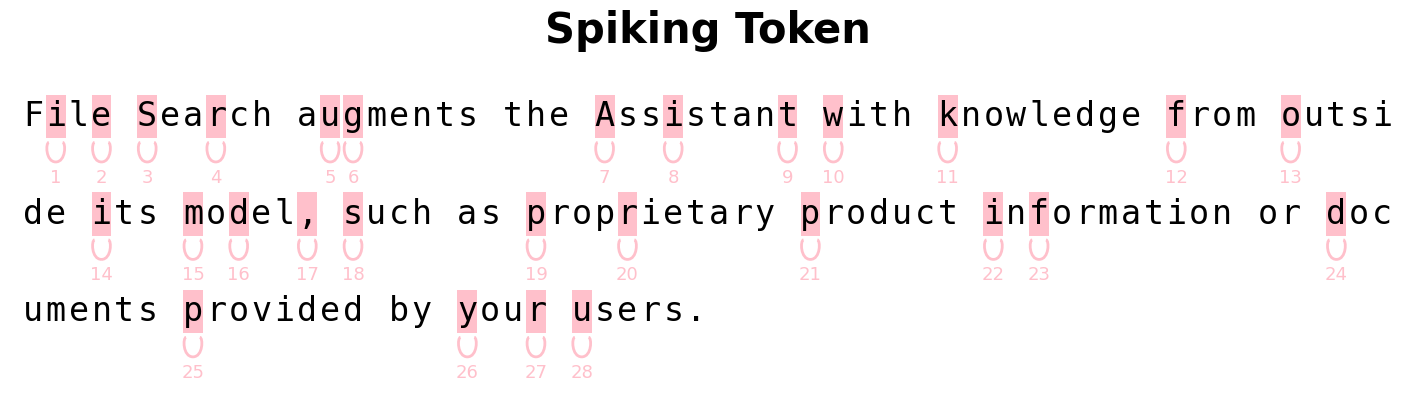

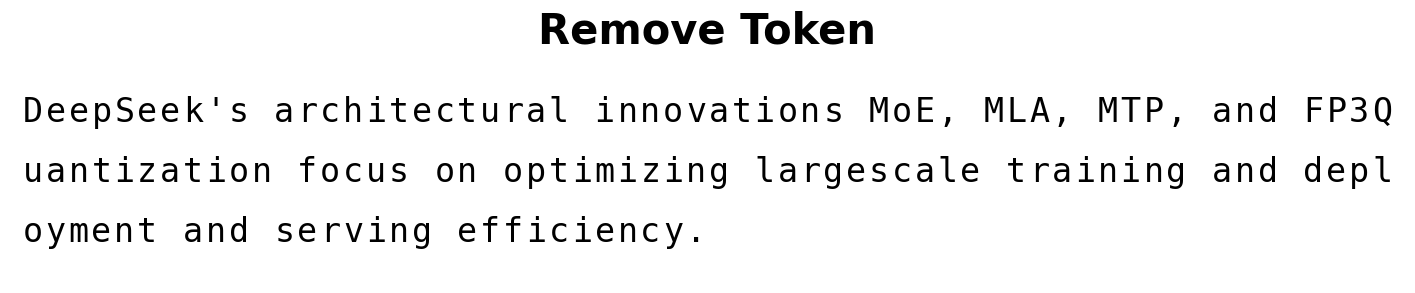

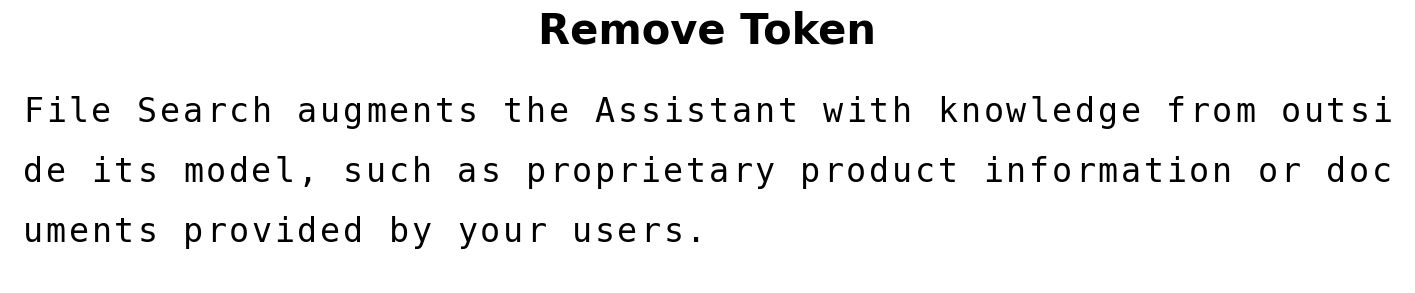

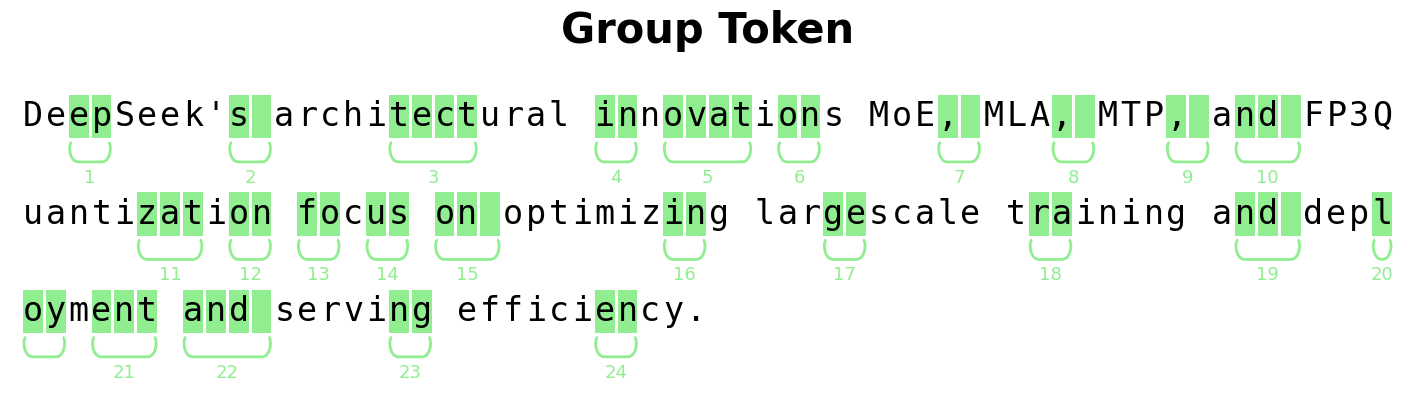

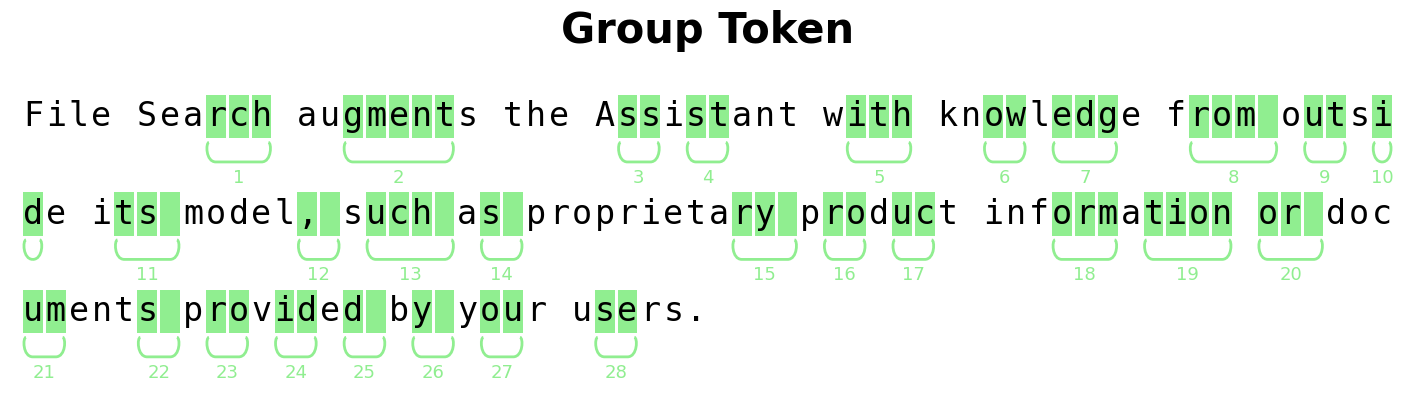

In [2]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base")

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [3]:
# cache vocabulary change 
magicab.cache_vocab_change(texts)

# update vocabulary :: Need to speed-up 'add_token' for ETokenizer 
magicab.update_vocab(max_size_change=2)

Begin vocabulary change caching ...
 - Inference took: 0.0767 seconds
 - Remove token detection took: 0.0002 seconds
 - Group token detection took: 0.0015 seconds
 :: Add new token ep  Id: 92
 :: Add new token s   Id: 93
 :: Add new token te  Id: 94
 :: Add new token tec  Id: 95
 :: Add new token tect  Id: 96
 :: Add new token in  Id: 97
 :: Add new token ov  Id: 98
 :: Add new token ova  Id: 99
 :: Add new token ovat  Id: 100
 :: Add new token on  Id: 101
 :: Add new token ,   Id: 102
 :: Add new token ,   Id: 103
 :: Add new token ,   Id: 104
 :: Add new token nd  Id: 105
 :: Add new token nd   Id: 106
 :: Add new token za  Id: 107
 :: Add new token zat  Id: 108
 :: Add new token on  Id: 109
 :: Add new token fo  Id: 110
 :: Add new token  o  Id: 111
 :: Add new token  on  Id: 112
 :: Add new token  on   Id: 113
 :: Add new token in  Id: 114
 :: Add new token al  Id: 115
 :: Add new token ale  Id: 116
 :: Add new token ale   Id: 117
 :: Add new token ra  Id: 118
 :: Add new token ng 

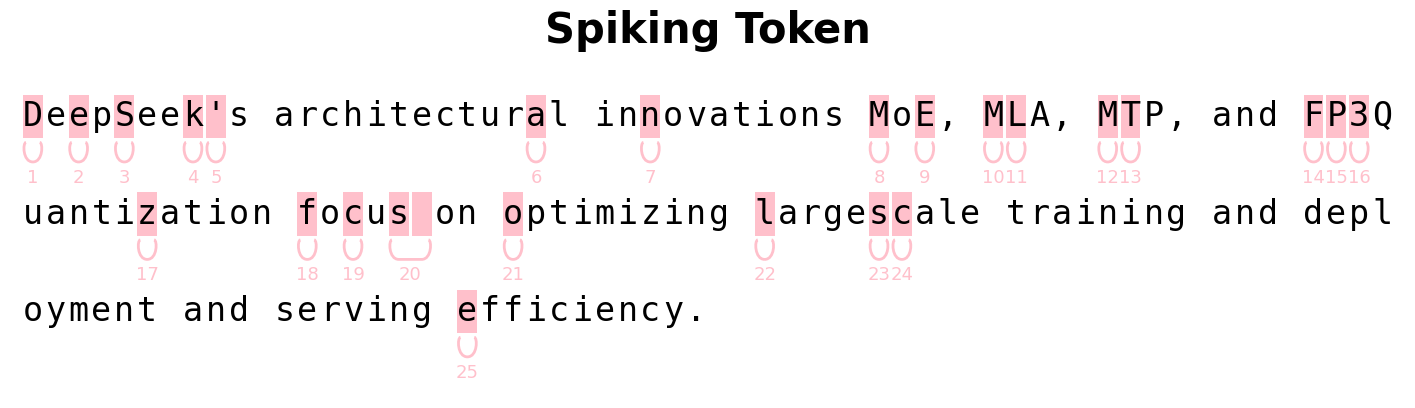

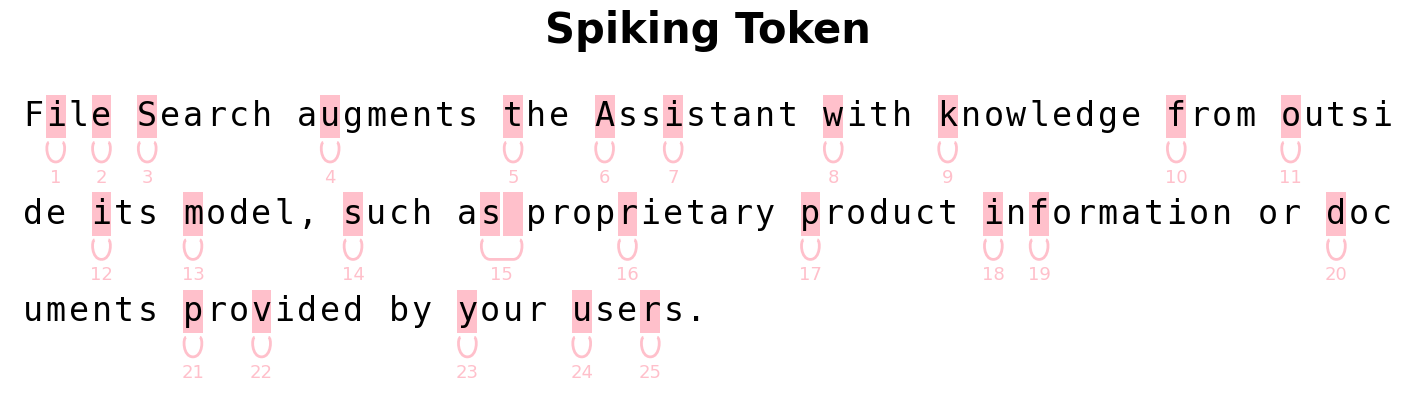

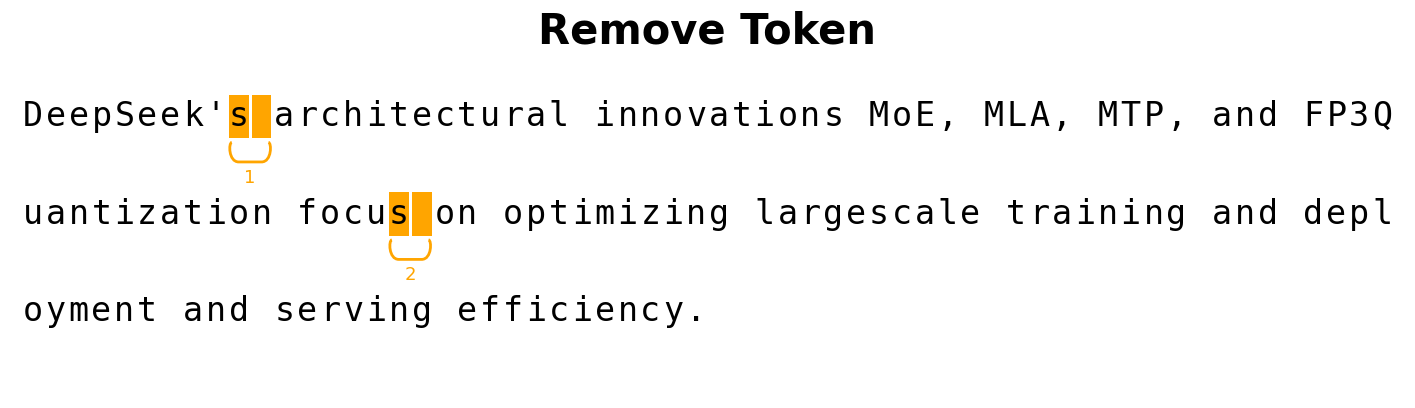

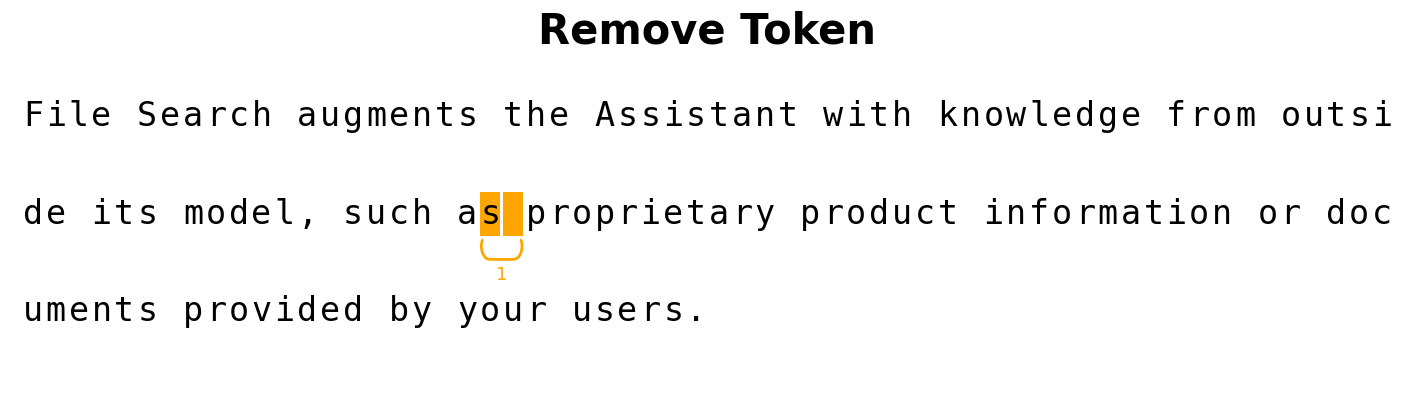

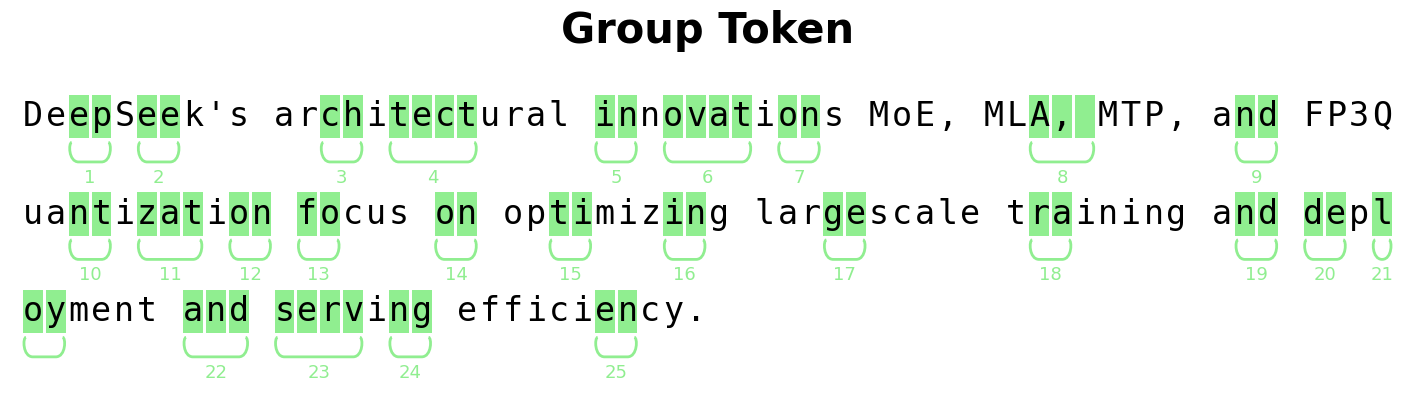

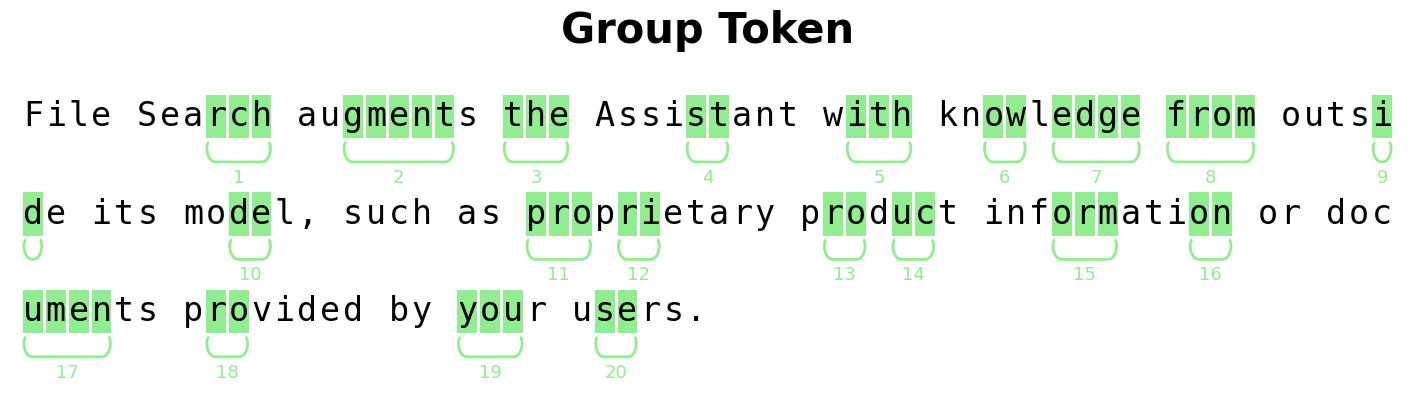

In [4]:
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [ ]:
# we should conduct token addition / removal via "absolute perplexity" instead of quantile here ? 

In [ ]:
from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab

# Update data with tokenizer (11min --> 40s with rust tokenization)
prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 


data_dir = "data/enwiki/"
block_size = 256
batch_size = 4
device_type = "cpu"

# Update vocabulary on training data
# vocabulary grows huge very soon, need to cap on allowed size change
update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change=200) 

Input file path:  data/enwiki/enwik8_clean.txt
Encoding data with tokenizer ...
Total tokens: 54482072
Vocab size: 92
train has 50,000,000 tokens
val has 2,000,000 tokens
test has 2,482,072 tokens
 :: Add new token 

  Id: 92
 :: Add new token 


  Id: 93
 :: Add new token m   Id: 94
 :: Add new token gi  Id: 95
 :: Add new token gin  Id: 96
 :: Add new token te  Id: 97
 :: Add new token s   Id: 98
 :: Add new token f   Id: 99
 :: Add new token se  Id: 100
 :: Add new token rs  Id: 101
 :: Add new token rst  Id: 102
 :: Add new token ga  Id: 103
 :: Add new token gai  Id: 104
 :: Add new token gain  Id: 105
 :: Add new token rl  Id: 106
 :: Add new token or  Id: 107
 :: Add new token in  Id: 108
 :: Add new token ing  Id: 109
 :: Add new token as  Id: 110
 :: Add new token ass  Id: 111
 :: Add new token di  Id: 112
 :: Add new token al  Id: 113
 :: Add new token lu  Id: 114
 :: Add new token lud  Id: 115
 :: Add new token ng  Id: 116
 :: Add new token th  Id: 117
 :: Add new token the 

KeyboardInterrupt: 

In [ ]:
# Speed is important for updating tokenizer, "add_token" is very slow in python, too
